<a href="https://colab.research.google.com/github/Naman09746/Deep-learning-/blob/main/Computer-vision/%20Real-time-hand-gesture-for-virtual-control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install --upgrade tensorflow
!pip install keras.utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class to load images and labels
# Dataset class to load images and labels
class GestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        img = img / 255.0  # Normalize
        img = img.astype(np.float32) # Convert image to float32

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

# Define the model (CNN with dropout layers)
class GestureModel(nn.Module):
    def __init__(self, num_classes):
        super(GestureModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))

        x = x.view(-1, 256 * 8 * 8)  # Flatten the output from the conv layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Data preprocessing (use transforms)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

# Load data (adjust dataset path accordingly)
dataset_path = "/content/drive/MyDrive/00"  # Path to the '00' folder

image_paths = []
labels = []

class_names = sorted(os.listdir(dataset_path))
class_labels = {name: idx for idx, name in enumerate(class_names)}  # Map each subfolder to a label

for class_name in class_names:
    class_folder_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_file)
            image_paths.append(image_path)
            labels.append(class_labels[class_name])

# Convert labels to numpy array
labels = np.array(labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create Dataset and DataLoader
train_dataset = GestureDataset(X_train, y_train, transform=transform)
val_dataset = GestureDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = GestureModel(num_classes=len(class_names)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Using device: cuda


In [5]:
# Training loop
num_epochs = 50
best_val_accuracy = 0.0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_gesture_model.pth")



Epoch [1/50], Train Loss: 1.7518, Train Accuracy: 35.69%, Val Loss: 0.1560, Val Accuracy: 98.75%
Epoch [2/50], Train Loss: 0.1932, Train Accuracy: 94.00%, Val Loss: 0.0277, Val Accuracy: 99.00%
Epoch [3/50], Train Loss: 0.0400, Train Accuracy: 98.69%, Val Loss: 0.0135, Val Accuracy: 99.50%
Epoch [4/50], Train Loss: 0.0317, Train Accuracy: 99.25%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch [5/50], Train Loss: 0.0329, Train Accuracy: 99.12%, Val Loss: 0.0010, Val Accuracy: 100.00%
Epoch [6/50], Train Loss: 0.0290, Train Accuracy: 99.12%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch [7/50], Train Loss: 0.0110, Train Accuracy: 99.69%, Val Loss: 0.0227, Val Accuracy: 99.25%
Epoch [8/50], Train Loss: 0.0278, Train Accuracy: 99.44%, Val Loss: 0.0013, Val Accuracy: 100.00%
Epoch [9/50], Train Loss: 0.0252, Train Accuracy: 99.19%, Val Loss: 0.0058, Val Accuracy: 99.75%
Epoch [10/50], Train Loss: 0.0308, Train Accuracy: 99.06%, Val Loss: 0.0305, Val Accuracy: 99.50%
Epoch [11/50], Train Loss

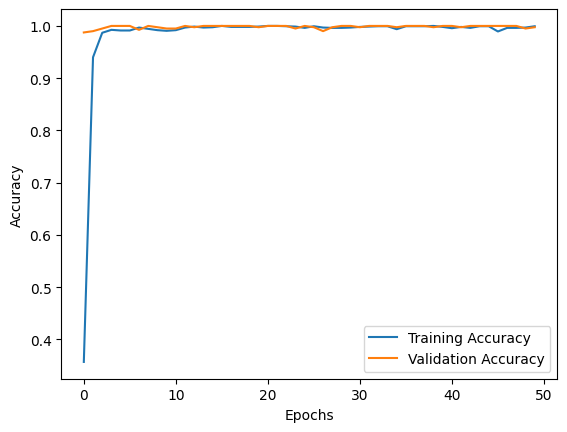

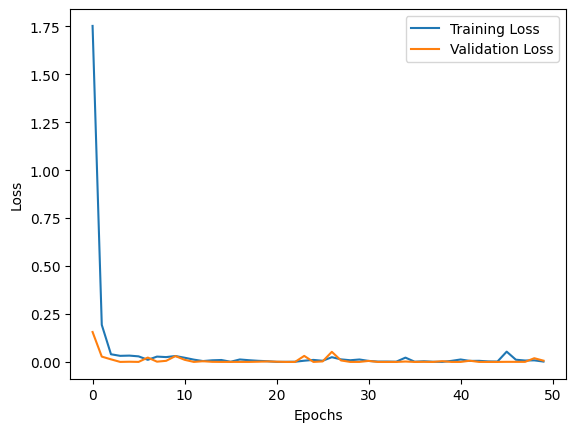

<ipython-input-6-0d015d48e92a>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gesture_model.pth'))


Test Accuracy: 100.00%


In [6]:
# Plot training and validation accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the test set (if available)
# You can use a similar approach for testing on a test dataset after saving the model
model.load_state_dict(torch.load('best_gesture_model.pth'))
model.eval()

test_accuracy = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:  # Use validation set for evaluation
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_accuracy += (predicted == targets).sum().item()

test_accuracy = test_accuracy / len(val_loader.dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [7]:
import pickle

# Save the model using PyTorch
torch.save(model.state_dict(), 'best_gesture_model.pth')  # Save only the model's weights

# Save the training history and other components if needed
history = {
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses
}

# Now, use pickle to save everything
with open('model_history.pkl', 'wb') as f:
    pickle.dump({
        'model_state_dict': model.state_dict(),
        'history': history
    }, f)

print("Model and history saved successfully.")


Model and history saved successfully.


# **Loading**

In [ ]:
import pickle
import torch

# Load the model and history from the pickle file
with open('model_history.pkl', 'rb') as f:
    saved_data = pickle.load(f)

# Extract the model's state dictionary and history
model_state_dict = saved_data['model_state_dict']
history = saved_data['history']

# Initialize the model again (must be the same model architecture)
model = GestureModel(num_classes=len(class_names)).to(device)

# Load the saved state_dict into the model
model.load_state_dict(model_state_dict)
model.eval()  # Set the model to evaluation mode

# You can now access the training history and use the model for evaluation or inference
train_accuracies = history['train_accuracies']
val_accuracies = history['val_accuracies']
train_losses = history['train_losses']
val_losses = history['val_losses']

# Print the training history (optional)
print("Training history loaded successfully.")
print(f"Last training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Last validation accuracy: {val_accuracies[-1]:.2f}%")

# Optionally, evaluate the model again on a test or validation dataset
# For example:
test_accuracy = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_accuracy += (predicted == targets).sum().item()

test_accuracy = test_accuracy / len(val_loader.dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [1]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# # from tensorflow import keras
# # from keras import utils
# # from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical

# # Define the dataset path
# dataset_path = "/content/drive/MyDrive/00"  # Path to the '00' folder in your Google Drive

# # Initialize lists to store image data and labels
# images = []
# labels = []

# # Class mapping (subfolder names as labels)
# class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
# class_labels = {name: idx for idx, name in enumerate(class_names)}  # Map each subfolder to a label

# # Load images and assign labels
# for class_name in class_names:
#     class_folder_path = os.path.join(dataset_path, class_name)  # Path to each gesture folder
#     for image_file in os.listdir(class_folder_path):  # Iterate over images
#         image_path = os.path.join(class_folder_path, image_file)
#         try:
#             # Load and preprocess the image
#             img = cv2.imread(image_path)
#             if img is not None:
#                 img = cv2.resize(img, (128, 128))  # Resize to 128x128
#                 img = img / 255.0  # Normalize pixel values to [0, 1]
#                 images.append(img)
#                 labels.append(class_labels[class_name])  # Use folder name as the label
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")

# # Convert to NumPy arrays
# images = np.array(images, dtype="float32")
# labels = np.array(labels, dtype="int")

# # One-hot encode the labels
# labels = to_categorical(labels, num_classes=len(class_names))

# # Split into training, validation, and test sets
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# # Print dataset details
# print(f"Loaded {len(images)} images across {len(class_names)} classes.")
# print(f"Class labels: {class_labels}")
# print(f"Training set: {len(X_train)} images")
# print(f"Validation set: {len(X_val)} images")
# print(f"Test set: {len(X_test)} images")


KeyboardInterrupt: 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation - This will augment the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
    rotation_range=30,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Filling mode for pixels
)

# For validation data, we only rescale the images (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Apply data augmentation to the training set
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Use the validation set as-is (no augmentation)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Enhanced CNN model with more layers and higher number of filters
model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 4 (Extra layer for complexity)
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer
    Flatten(),

    # Fully Connected Layer 1
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Dropout for regularization

    # Fully Connected Layer 2
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Dropout for regularization

    # Output Layer (Softmax for multi-class classification)
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,241,418 (19.99 MB)

 Trainable params: 5,241,418 (19.99 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import tensorflow as tf
# Model checkpoint to save the best weights during training
checkpoint = ModelCheckpoint('best_model.keras', # Changed the extension to .keras
                             save_best_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# Reduce learning rate if validation accuracy doesn't improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=3,
                               min_lr=1e-6,
                               verbose=1)

# TensorBoard for monitoring training
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
